**get model coordinates**

In [ ]:
import plotly.express as px
import pandas as pd
import numpy as np

coor = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Coron/met_ model/distan_lat42.58lon-8.8046p3R4Km.csv")
px.set_mapbox_access_token("pk.eyJ1IjoiZ3JhbmFudHVpbiIsImEiOiJja3B4dGU4OTkwMTFmMm9ycnNhMjJvaGJqIn0.VWzx_PkD9A5cSUVsn_ijCA")
px.scatter_mapbox(coor, hover_data=['distance'],lat='lat', lon='lon',color='distance', title="nearest points",
                           color_continuous_scale=px.colors.cyclical.IceFire,)

In [ ]:
pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Coron/station_data/prec_o.csv").set_index("time").info()

<class 'pandas.core.frame.DataFrame'>
Index: 262224 entries, 2018-01-01 00:10:00 to 2022-12-31 00:00:00
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   prec_o  259033 non-null  float64
dtypes: float64(1)
memory usage: 4.0+ MB


**get station and sample max gust hour before**

In [ ]:


station = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Coron/station_data/prec_o.csv", usecols = ["time","prec_o"],parse_dates=["time"]).set_index("time")
print("raw data\n",station.head(24))

#show duplicated
df_duplicate = station[station.index.duplicated()]
print("duplicated")
print(df_duplicate)

#delete duplicated and resample
station = station[~station.index.duplicated(keep='first')]

#reample with mean and new function

station = station.resample("H",label="right",closed="right").sum()

#label
interval=pd.IntervalIndex.from_tuples([(-0.5,0.1), (0.1, 40)])
labels=['No Rain', 'Rain']



#show mean function
station["prec_o_l"] = pd.cut(station["prec_o"], bins=interval,retbins=False,labels=labels).map({a:b for a,b in zip(interval,labels)}).astype('category')
clim = station["prec_o_l"].value_counts(normalize=True)

print("climatology\n",clim)




raw data
                      prec_o
time                       
2018-01-01 00:10:00     0.0
2018-01-01 00:20:00     0.0
2018-01-01 00:30:00     0.0
2018-01-01 00:40:00     0.0
2018-01-01 00:50:00     0.0
2018-01-01 01:00:00     0.0
2018-01-01 01:10:00     0.0
2018-01-01 01:20:00     0.0
2018-01-01 01:30:00     0.0
2018-01-01 01:40:00     0.0
2018-01-01 01:50:00     0.0
2018-01-01 02:00:00     0.0
2018-01-01 02:10:00     0.0
2018-01-01 02:20:00     0.0
2018-01-01 02:30:00     0.0
2018-01-01 02:40:00     0.0
2018-01-01 02:50:00     0.0
2018-01-01 03:00:00     0.0
2018-01-01 03:10:00     0.0
2018-01-01 03:20:00     0.0
2018-01-01 03:30:00     0.0
2018-01-01 03:40:00     0.0
2018-01-01 03:50:00     0.0
2018-01-01 04:00:00     0.0
duplicated
                     prec_o
time                       
2018-03-25 03:00:00     0.0
2018-03-25 03:10:00     0.0
2018-03-25 03:20:00     0.0
2018-03-25 03:30:00     0.0
2018-03-25 03:40:00     0.0
2018-03-25 03:50:00     0.0
2019-03-31 03:00:00     0.0

In [ ]:
station.sample(50)

,prec_o,prec_o_l
time,,
2020-08-15 21:00:00,0.0,No Rain
2022-10-29 19:00:00,0.0,No Rain
2021-11-29 03:00:00,0.0,No Rain
2021-12-11 19:00:00,0.0,No Rain
2019-09-15 19:00:00,0.0,No Rain
2019-04-04 02:00:00,0.0,No Rain
2020-11-08 12:00:00,0.0,No Rain
2020-04-07 14:00:00,0.0,No Rain
2019-04-23 01:00:00,0.6,Rain


**get meteorologic model d0**

In [ ]:
#ria forecast d0
met_model = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Coron/met_ model/lat42.58lon-8.8046p3R4KmD0.csv",parse_dates=["time"]).drop(columns=["Unnamed: 0"]).set_index("time")
met_model.drop_duplicates().info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 42021 entries, 2018-01-01 01:00:00 to 2023-01-01 23:00:00
Data columns (total 75 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   dir0         42021 non-null  float64
 1   snow_prec0   42021 non-null  float64
 2   snowlevel0   42021 non-null  float64
 3   mod0         42021 non-null  float64
 4   wind_gust0   42021 non-null  float64
 5   mslp0        42021 non-null  float64
 6   temp0        42021 non-null  float64
 7   rh0          42021 non-null  float64
 8   visibility0  42021 non-null  float64
 9   lhflx0       42021 non-null  float64
 10  lwflx0       42021 non-null  float64
 11  conv_prec0   42021 non-null  float64
 12  prec0        42021 non-null  float64
 13  swflx0       42021 non-null  float64
 14  shflx0       42021 non-null  float64
 15  cape0        42021 non-null  float64
 16  cin0         42021 non-null  float64
 17  cfh0         42021 non-null  float64
 18  cfl0       

**Concatenate and dropnan**

In [ ]:
df_all = pd.concat([station,met_model],axis=1).dropna()
df_all.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 41975 entries, 2018-01-01 01:00:00 to 2022-12-30 23:00:00
Data columns (total 77 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   prec_o       41975 non-null  float64 
 1   prec_o_l     41975 non-null  category
 2   dir0         41975 non-null  float64 
 3   snow_prec0   41975 non-null  float64 
 4   snowlevel0   41975 non-null  float64 
 5   mod0         41975 non-null  float64 
 6   wind_gust0   41975 non-null  float64 
 7   mslp0        41975 non-null  float64 
 8   temp0        41975 non-null  float64 
 9   rh0          41975 non-null  float64 
 10  visibility0  41975 non-null  float64 
 11  lhflx0       41975 non-null  float64 
 12  lwflx0       41975 non-null  float64 
 13  conv_prec0   41975 non-null  float64 
 14  prec0        41975 non-null  float64 
 15  swflx0       41975 non-null  float64 
 16  shflx0       41975 non-null  float64 
 17  cape0        41975 non-null  float

**Compare accuracy prec0, prec1, prec2 versus prec_o_l**

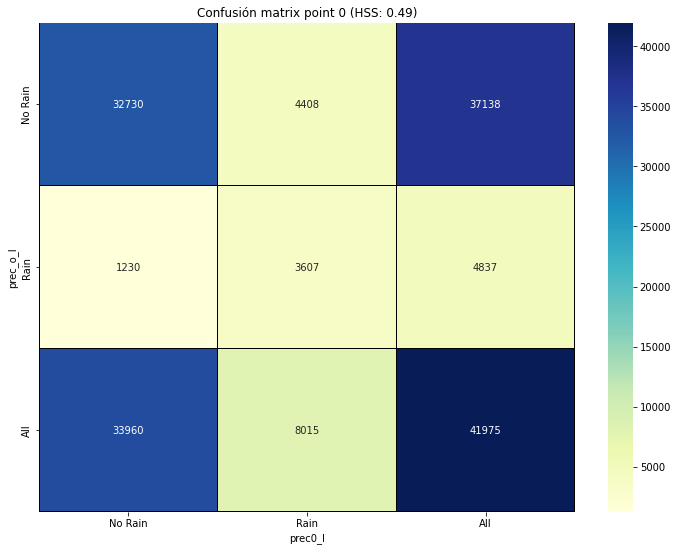

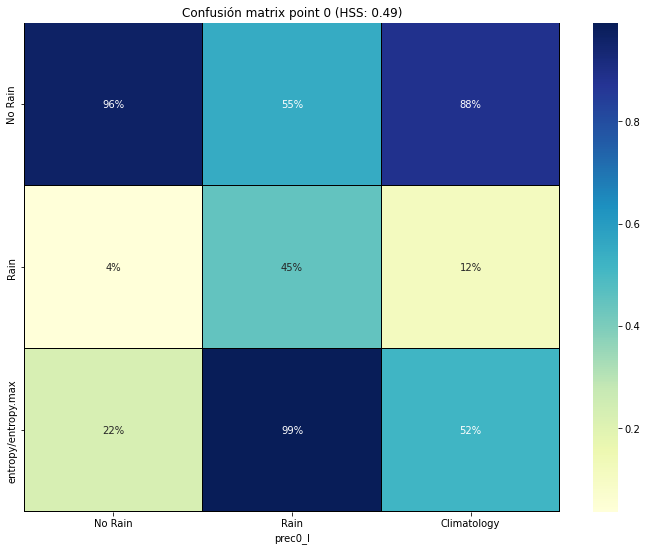

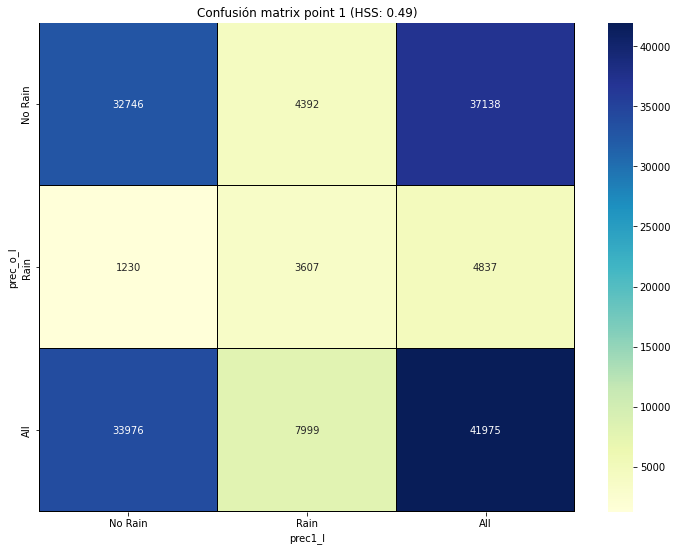

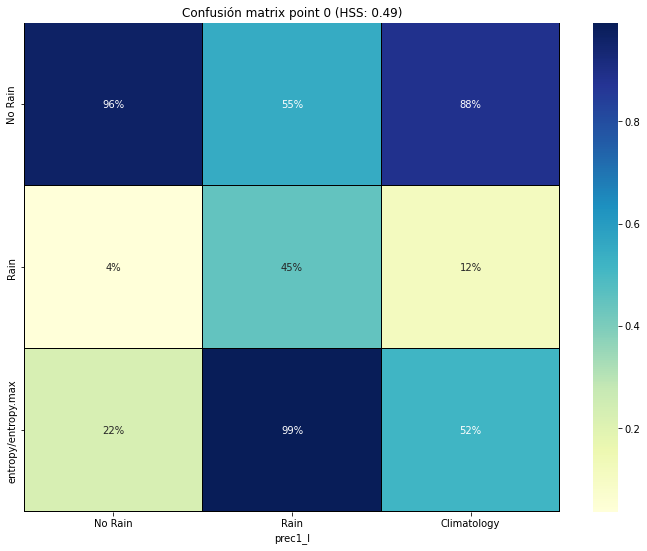

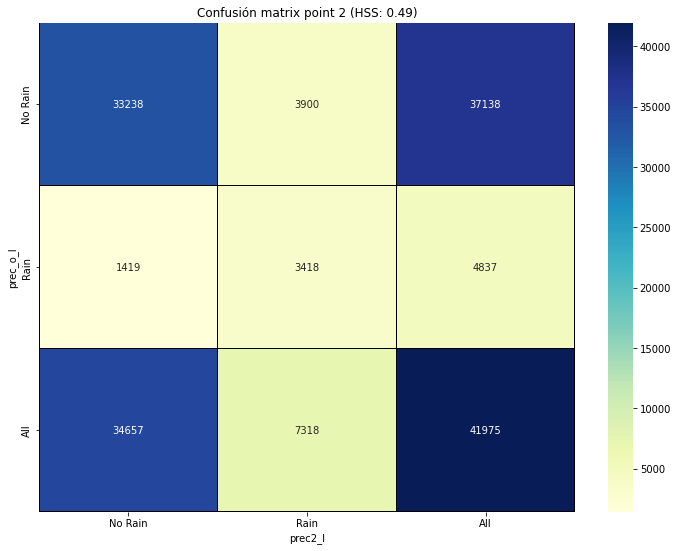

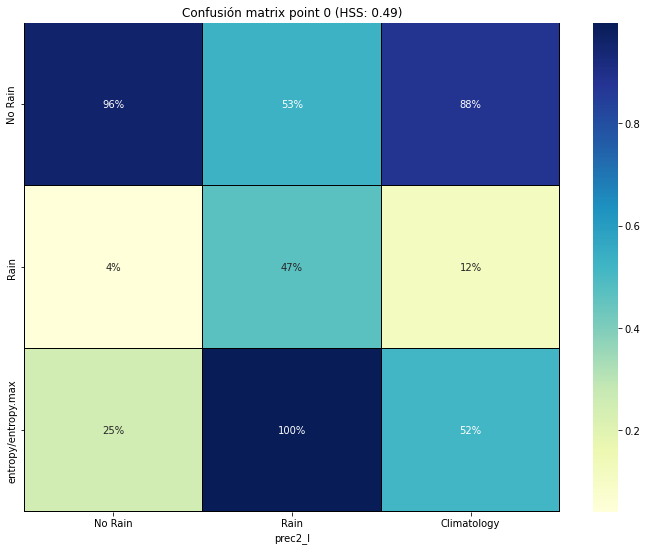

In [ ]:
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import math
from scipy.stats import entropy
import seaborn as sns

def HSS(y_true,y_pred):
  """
  Heidke skill score
  """
  cm = pd.crosstab(y_true, y_pred)
  a = cm.values[0,0]
  b = cm.values[1,0]
  c = cm.values[0,1]
  d = cm.values[1,1]
  hss = 2*(a*d-b*c)/((a+c)*(c+d)+(a+b)*(b+d))
  return round(hss,2)


#label dir 0,1 and 2
df_all["prec0_l"] = pd.cut(df_all["prec0"], bins=interval,retbins=False,labels=labels).map({a:b for a,b in zip(interval,labels)}).astype('category')
df_all["prec1_l"] = pd.cut(df_all["prec1"], bins=interval,retbins=False,labels=labels).map({a:b for a,b in zip(interval,labels)}).astype('category')
df_all["prec2_l"] = pd.cut(df_all["prec2"], bins=interval,retbins=False,labels=labels).map({a:b for a,b in zip(interval,labels)}).astype('category')

hss0 = HSS(df_all.prec_o_l, df_all.prec0_l)
hss1 = HSS(df_all.prec_o_l, df_all.prec1_l)
hss2 = HSS(df_all.prec_o_l, df_all.prec2_l)

#point 0
plt.figure(figsize=(12, 9))
plt.title("Confusión matrix point 0 (HSS: {})".format(hss0))
global_sc = pd.crosstab(df_all.prec_o_l, df_all.prec0_l,margins=True,)
sns.heatmap(global_sc,annot=True,cmap="YlGnBu",fmt='.0f',linewidths=.3, linecolor='black');


plt.figure(figsize=(12, 9))
plt.title("Confusión matrix point 0 (HSS: {})".format(hss0))
column_sc = pd.crosstab(df_all.prec_o_l, df_all.prec0_l, margins=True,normalize="columns")
column_sc = column_sc.append(pd.DataFrame(entropy(column_sc,base=2)/(math.log2(column_sc.shape[0])),columns=["entropy/entropy.max"],
                    index=column_sc.columns).T).rename(columns={"All":"Climatology"})
sns.heatmap(column_sc,annot=True,cmap="YlGnBu",fmt='.0%',linewidths=.3, linecolor='black');

#point1
plt.figure(figsize=(12, 9))
plt.title("Confusión matrix point 1 (HSS: {})".format(hss1))
global_sc = pd.crosstab(df_all.prec_o_l, df_all.prec1_l,margins=True,)
sns.heatmap(global_sc,annot=True,cmap="YlGnBu",fmt='.0f',linewidths=.3, linecolor='black');

plt.figure(figsize=(12, 9))
plt.title("Confusión matrix point 0 (HSS: {})".format(hss1))
column_sc = pd.crosstab(df_all.prec_o_l, df_all.prec1_l, margins=True,normalize="columns")
column_sc = column_sc.append(pd.DataFrame(entropy(column_sc,base=2)/(math.log2(column_sc.shape[0])),columns=["entropy/entropy.max"],
                   index=column_sc.columns).T).rename(columns={"All":"Climatology"})
sns.heatmap(column_sc,annot=True,cmap="YlGnBu",fmt='.0%',linewidths=.3, linecolor='black');


#point2
plt.figure(figsize=(12, 9))
plt.title("Confusión matrix point 2 (HSS: {})".format(hss2))
global_sc = pd.crosstab(df_all.prec_o_l, df_all.prec2_l,margins=True,)
sns.heatmap(global_sc,annot=True,cmap="YlGnBu",fmt='.0f',linewidths=.3, linecolor='black');

plt.figure(figsize=(12, 9))
plt.title("Confusión matrix point 2 (HSS: {})".format(hss2))
column_sc = pd.crosstab(df_all.prec_o_l, df_all.prec2_l, margins=True,normalize="columns")
column_sc = column_sc.append(pd.DataFrame(entropy(column_sc,base=2)/(math.log2(column_sc.shape[0])),columns=["entropy/entropy.max"],
                    index=column_sc.columns).T).rename(columns={"All":"Climatology"})
sns.heatmap(column_sc,annot=True,cmap="YlGnBu",fmt='.0%',linewidths=.3, linecolor='black');

#delete met model label columns
df_all = df_all.drop(["prec0_l","prec1_l","prec2_l"],axis=1)

In [ ]:
df_all.columns[2:]

Index(['dir0', 'snow_prec0', 'snowlevel0', 'mod0', 'wind_gust0', 'mslp0',
       'temp0', 'rh0', 'visibility0', 'lhflx0', 'lwflx0', 'conv_prec0',
       'prec0', 'swflx0', 'shflx0', 'cape0', 'cin0', 'cfh0', 'cfl0', 'cfm0',
       'cft0', 'HGT5000', 'HGT8500', 'T5000', 'T8500', 'dir1', 'snow_prec1',
       'snowlevel1', 'mod1', 'wind_gust1', 'mslp1', 'temp1', 'rh1',
       'visibility1', 'lhflx1', 'lwflx1', 'conv_prec1', 'prec1', 'swflx1',
       'shflx1', 'cape1', 'cin1', 'cfh1', 'cfl1', 'cfm1', 'cft1', 'HGT5001',
       'HGT8501', 'T5001', 'T8501', 'dir2', 'snow_prec2', 'snowlevel2', 'mod2',
       'wind_gust2', 'mslp2', 'temp2', 'rh2', 'visibility2', 'lhflx2',
       'lwflx2', 'conv_prec2', 'prec2', 'swflx2', 'shflx2', 'cape2', 'cin2',
       'cfh2', 'cfl2', 'cfm2', 'cft2', 'HGT5002', 'HGT8502', 'T5002', 'T8502',
       'hour', 'month', 'dayofyear', 'weekofyear'],
      dtype='object')

**Add time variables. Train machine learning and results**

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from lightgbm.sklearn import LGBMClassifier
from sklearn.model_selection import train_test_split

df_all["hour"] = df_all.index.hour
df_all["month"] = df_all.index.month
df_all["dayofyear"] = df_all.index.dayofyear
df_all["weekofyear"] = df_all.index.isocalendar().week.astype(int)

#numpy randomseed
np.random.seed(1)

# target variable
Y = df_all.prec_o_l
X = df_all[["prec0","visibility0","mod0","dir0","prec1","mod1","dir1","prec2",
            "mod2","dir2","hour","month","dayofyear","weekofyear"]]
X = df_all[df_all.columns[2:]]

HSS_t = []
for t in range (0,2):
  X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=0.1, )
  ml_model = LGBMClassifier(n_estimators=200).fit(X_train,y_train)
  #ml_model = ExtraTreesClassifier(n_estimators=200).fit(X_train,y_train)
  y_pred = ml_model.predict(X_test)
  HSS_t.append(HSS(y_test,y_pred))
  print("machine learning number:",t)
  
print("HSS",HSS_t) 
print("Accuracy Machine learning models")
df_r=pd.DataFrame({"HSS":HSS_t,});
df_r.describe()



machine learning number: 0
machine learning number: 1
HSS [0.57, 0.54]
Accuracy Machine learning models


,HSS
count,2.000000
mean,0.555000
std,0.021213
min,0.540000
25%,0.547500
50%,0.555000
75%,0.562500
max,0.570000


**Show machine learning results**

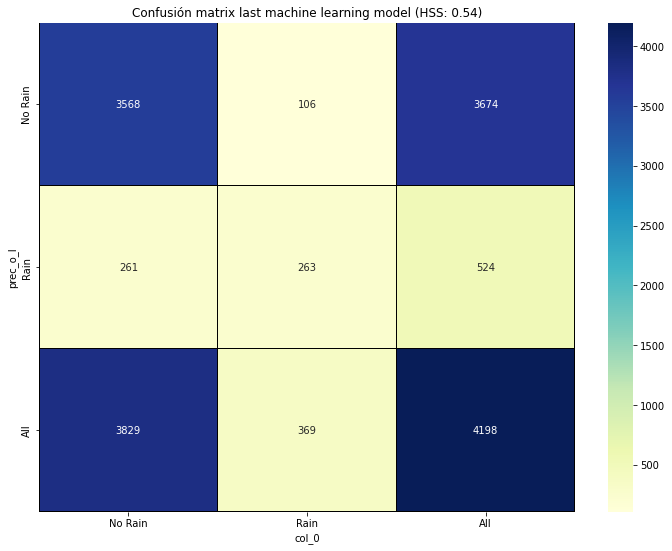

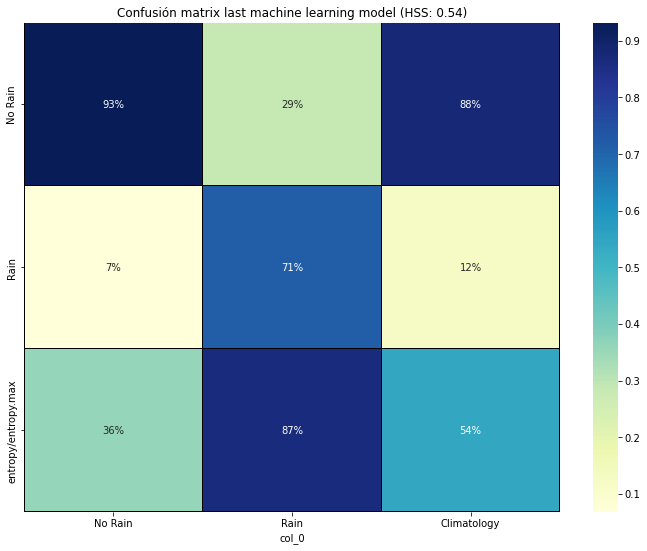

In [ ]:
plt.figure(figsize=(12, 9))
plt.title("Confusión matrix last machine learning model (HSS: {})".format(HSS_t[-1]))
global_sc_ml = pd.crosstab(y_test, y_pred, margins=True,)
sns.heatmap(global_sc_ml[global_sc.columns],annot=True,cmap="YlGnBu",fmt='.0f',linewidths=.3, linecolor='black');


plt.figure(figsize=(12, 9))
plt.title("Confusión matrix last machine learning model (HSS: {})".format(HSS_t[-1]))
column_sc_ml = pd.crosstab(y_test, y_pred, margins=True,normalize="columns")
column_sc_ml = column_sc_ml.append(pd.DataFrame(entropy(column_sc_ml,base=2)/(math.log2(column_sc_ml.shape[0])),columns=["entropy/entropy.max"],
                    index=column_sc_ml.columns).T).rename(columns={"All":"Climatology"})
sns.heatmap(column_sc_ml[column_sc.columns],annot=True,cmap="YlGnBu",fmt='.0%',linewidths=.3, linecolor='black');

**Save algorithm**

In [ ]:
import pickle
from sklearn.pipeline import Pipeline


estimators = [('ml_model', ml_model)]
pipe = Pipeline(estimators)
print(pipe)
al_file={"x_var":X.columns,"coor":coor,"pipe":pipe}
pickle.dump(al_file, open("/content/drive/MyDrive/Colab Notebooks/Coron/algorithms/prec_coron_d0.al", 'wb'))

Pipeline(steps=[('ml_model', LGBMClassifier(n_estimators=200))])
